In [1]:
## jupyter notebook to simulate the range of the nuclear recoils in a given decay chain

import numpy as np
import matplotlib.pyplot as plt
import alpha_recoil_sim as ar
import importlib
from scipy.interpolate import CubicSpline

In [2]:
importlib.reload(ar)

## make dictionary containing decay chain information for a given list of isotopes
path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC"

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']

iso_dict = {}

for iso in iso_list:
    ciso = iso[:2].lower()
    cA = iso[-3:]
    iso_dict[iso] = ar.parse_decay_chain(path + "/decay_data/" + ciso + "_" + cA + "_decay_chain.txt")

In [3]:
## Load the Monte Carlo data from SRIM
import pickle

data_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

with open(data_path + 'SRIM_MC_events.pkl', 'rb') as f:
    MC_dict = pickle.load(f)

In [4]:
### load the ESTAR data and make a dictionary with interpolation functions
matlist = ['SiO2', 'Au', 'Ag', 'tissue'] ## materials to use
matdensity = [2.0, 19.31, 10.47, 1.05] ## densities in g/cm^3
beta_dict = {}

MeV_to_keV = 1000
cm_to_nm = 1e7

for dens,mat in zip(matdensity, matlist):

    estar_data = np.loadtxt(path + "/decay_data/" + mat.lower() + '_estar.txt', skiprows=2)
    interp_func = CubicSpline(estar_data[:,0]*MeV_to_keV, estar_data[:,3]*MeV_to_keV*dens/cm_to_nm)

    beta_dict[mat] = interp_func ## interpolation function taking energy in keV and returning energy loss in keV/nm

In [99]:
## Run over the isotopes and various shell materials, and save data
importlib.reload(ar)

iso_list = ['Ac-225'] #, 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
shell_mat = ['Au'] #['SiO2', 'Au', 'Ag']
shell_thick = [100] #[220, 50, 65]
inner_rad = 12.5
N = 2000

out_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/SRIM_Data/'

sim_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        print("Working on %d events for %s with %s shell"%(N, iso, shell))

        sphere_dict = {"inner_radius": inner_rad, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", 
                       "shell_material": shell, "starting_loc": "core_surface"}

        sim_dict[iso + "_" + shell] = ar.sim_N_events(N, iso, iso_dict, sphere_dict, MC_dict, beta_dict=beta_dict,
                                                      exterior_mat='tissue', simulate_alpha=True, simulate_beta=True,
                                                      seed=493495)

with open(data_path + 'simulation_data.pkl', 'wb') as f:
    pickle.dump(sim_dict, f)

Working on 2000 events for Ac-225 with Au shell
MC iteration:  0  of  2000


/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:278: RuntimeWarning: invalid value encountered in scalar divide
  ct = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:283: RuntimeWarning: invalid value encountered in divide
  u = u / np.linalg.norm(u)   # normalize the axis vector
/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/Sphere_Recoils_MC/alpha_recoil_sim.py:824: RuntimeWarning: invalid value encountered in divide
  


In [100]:
with open(data_path + 'simulation_data.pkl', 'rb') as f:
    sim_dict = pickle.load(f)

Found 1 bad points out of 2000: 0.050%


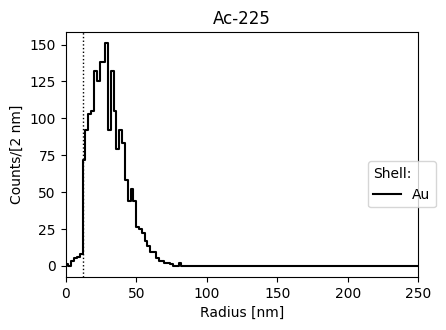

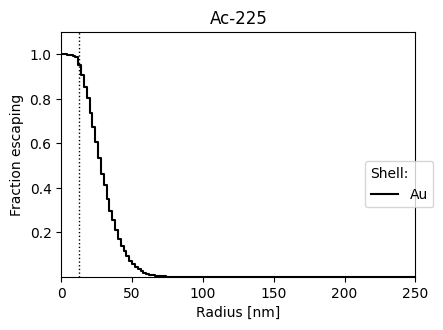

In [101]:
#iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
#shell_mat = ['SiO2', 'Au', 'Ag']
#shell_thick = [350, 100, 150]


# Make a plot of the final position distribution and escape fraction for each isotope
col_list = ['k', 'gold', 'gray']
importlib.reload(ar)

thresh_list = [0.5, 0.1, 0.01, 0.001]
sty = ['-', '--', ':']

fig_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/plots/'

df = plt.figure(facecolor='white', figsize=(12,6))
sf = plt.figure(facecolor='white', figsize=(12,6))
idx = 1

thickness_dict = {}

for iso in iso_list:
    for j,shell in enumerate(shell_mat):

        sphere_dict = {"inner_radius": inner_rad, "outer_shell_thick": shell_thick[0], "inner_material": "SiO2", "shell_material": shell}

        x, y, s = ar.analyze_simulation( sim_dict[iso + "_" + shell] )
        plt.figure(df.number)
        plt.subplot(2,3,idx)
        plt.step(x,y,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Counts/[2 nm]")
        plt.xlim(0,250)

        plt.figure(sf.number)
        plt.subplot(2,3,idx)
        plt.step(x,s,color=col_list[j],where='mid', label=shell)
        plt.xlabel("Radius [nm]")
        plt.ylabel("Fraction escaping")
        plt.xlim(0,250)

        thick = np.interp(thresh_list, s[::-1], x[::-1])
        thickness_dict[iso + "_" + shell] = thick

    plt.figure(df.number)
    yy = plt.ylim()
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    plt.figure(sf.number)
    #plt.gca().set_yscale('log')
    yy = [1e-4, 1.1]
    rin = sphere_dict['inner_radius']
    plt.plot([rin, rin], yy, 'k:', lw=1)
    plt.ylim(yy)
    plt.title(iso)

    idx +=1

plt.figure(df.number)
#df.subplots_adjust(hspace=0.4)
leg=plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "range_vs_iso.pdf")

plt.figure(sf.number)
#sf.subplots_adjust(hspace=0.4)
leg = plt.legend(bbox_to_anchor=(1.07, 0.5), title="Shell:")
leg._legend_box.align = "left"
plt.tight_layout()
plt.savefig(fig_path + "escape_vs_iso.pdf")


In [22]:
#iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
#shell_mat = ['SiO2', 'Au', 'Ag']
#shell_thick = [220, 50, 65]


# Make a plot of the final position distribution and escape fraction for each isotope
col_list = ['k', 'gold', 'gray']
importlib.reload(ar)

thresh_list = [0.5, 0.1, 0.01, 0.001]
sty = ['-', '--', ':']

fig_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/plots/'

df = plt.figure(facecolor='white', figsize=(12,6))
sf = plt.figure(facecolor='white', figsize=(12,6))
idx = 1

thickness_dict = {}

nm_to_um = 1e-3

reprocess_hists = False
if(reprocess_hists):

    for k,iso in enumerate(iso_list):
        for j,shell in enumerate(shell_mat):

            sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

            router = sphere_dict['inner_radius'] + sphere_dict['outer_shell_thick']
            bins_to_use = np.logspace(-1, 8, 400)
            bins_size = np.diff(bins_to_use)

            h_NR, h_alpha, h_beta, bc, volume = ar.analyze_energy_deposits( sim_dict[iso + "_" + shell], bins_to_use=bins_to_use )

            np.savez(fig_path + "energy_deposits_%s_%s.npz"%(iso, shell), h_NR=h_NR, h_alpha=h_alpha, h_beta=h_beta, bc=bc, volume=volume)


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
#### linear binning

iso_list = ['Ac-225', 'Pb-212', 'At-211', 'Th-227', 'Ra-223']
shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [220, 50, 65]


# Make a plot of the final position distribution and escape fraction for each isotope
col_list = ['k', 'gold', 'gray']
importlib.reload(ar)

thresh_list = [0.5, 0.1, 0.01, 0.001]
sty = ['-', '--', ':']

fig_path = '/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/alpha_recoils_Grimm/plots/'

df = plt.figure(facecolor='white', figsize=(12,6))
sf = plt.figure(facecolor='white', figsize=(12,6))
idx = 1

thickness_dict = {}

nm_to_um = 1e-3

reprocess_hists = True
if(reprocess_hists):

    for k,iso in enumerate(iso_list):
        for j,shell in enumerate(shell_mat):

            sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

            router = sphere_dict['inner_radius'] + sphere_dict['outer_shell_thick']
            bins_to_use = np.linspace(0, 125e3, 125)
            bins_size = np.diff(bins_to_use)

            h_NR, h_alpha, h_beta, bc, volume = ar.analyze_energy_deposits( sim_dict[iso + "_" + shell], bins_to_use=bins_to_use )

            np.savez(fig_path + "energy_deposits_lin_bin_%s_%s.npz"%(iso, shell), h_NR=h_NR, h_alpha=h_alpha, h_beta=h_beta, bc=bc, volume=volume)

Working on event 0 of 10000
Working on event 1000 of 10000
Working on event 2000 of 10000
Working on event 3000 of 10000
Working on event 4000 of 10000
Working on event 5000 of 10000
Working on event 6000 of 10000
Working on event 7000 of 10000
Working on event 8000 of 10000
Working on event 9000 of 10000
Working on event 0 of 10000
Working on event 1000 of 10000
Working on event 2000 of 10000
Working on event 3000 of 10000
Working on event 4000 of 10000
Working on event 5000 of 10000
Working on event 6000 of 10000
Working on event 7000 of 10000
Working on event 8000 of 10000
Working on event 9000 of 10000
Working on event 0 of 10000
Working on event 1000 of 10000
Working on event 2000 of 10000
Working on event 3000 of 10000
Working on event 4000 of 10000
Working on event 5000 of 10000
Working on event 6000 of 10000
Working on event 7000 of 10000
Working on event 8000 of 10000
Working on event 9000 of 10000
Working on event 0 of 10000
Working on event 1000 of 10000
Working on event 200

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Ac-225 28369.73245807505
Ac-225 27372.19339678696
Pb-212 8641.713403702573
Pb-212 7787.548894775972
At-211 6894.196434039966
At-211 6695.921675936866
Th-227 33264.74573748574
Th-227 32077.21255612706
Ra-223 27325.30066659791
Ra-223 26245.34036070206


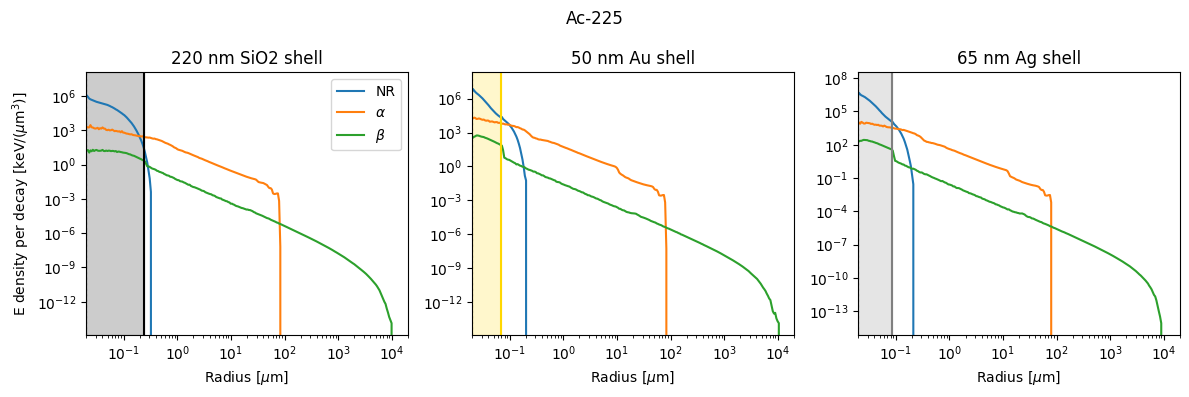

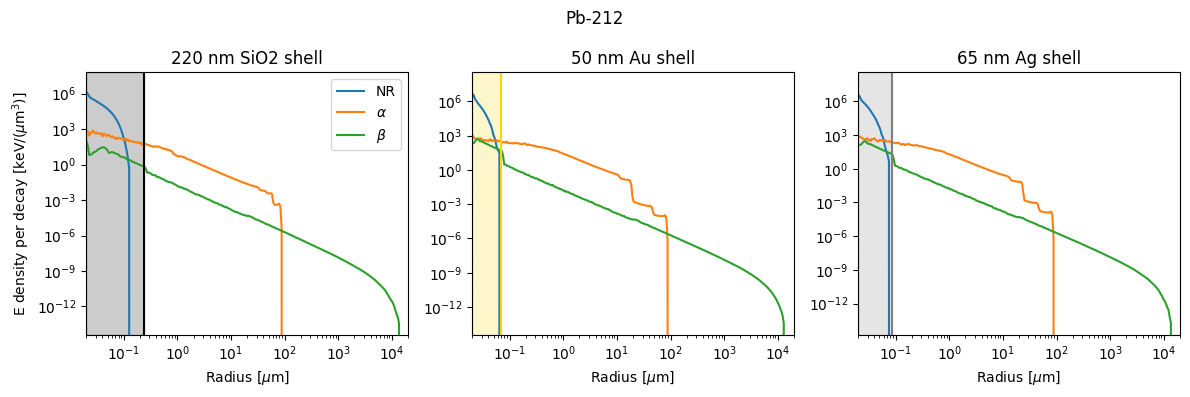

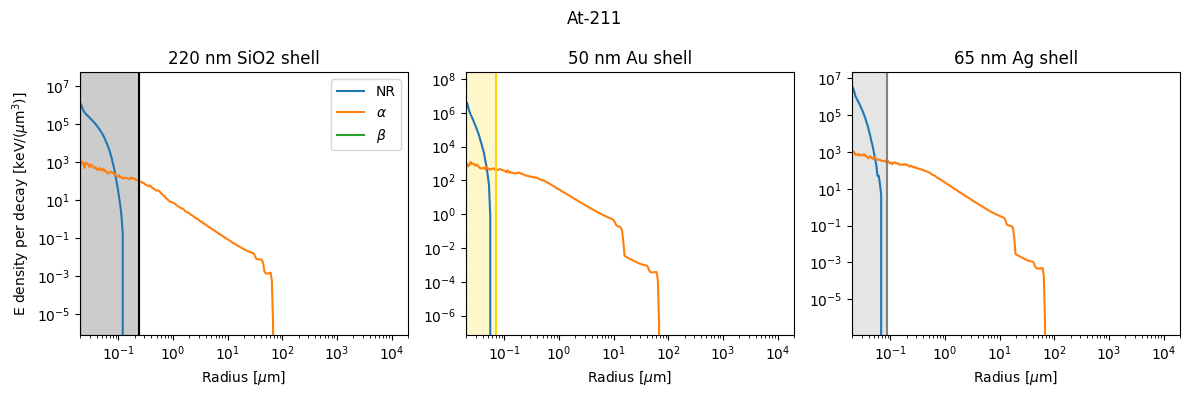

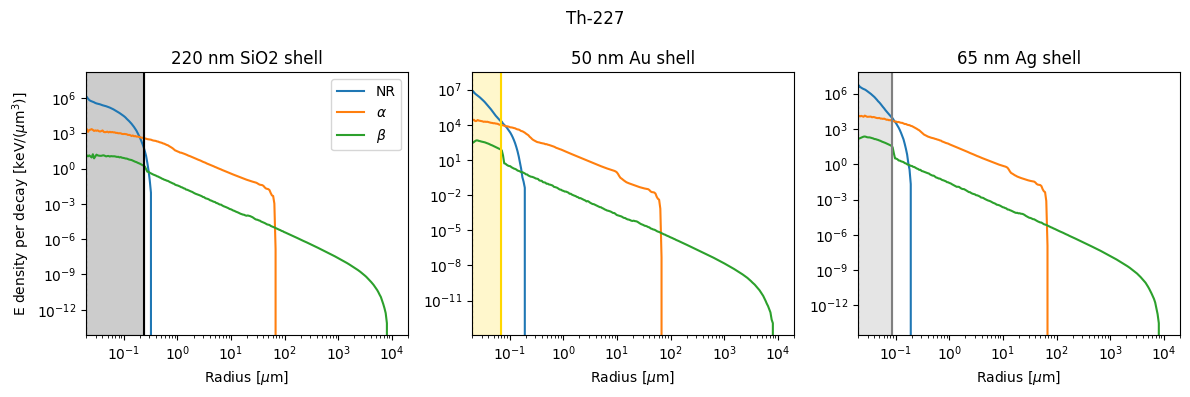

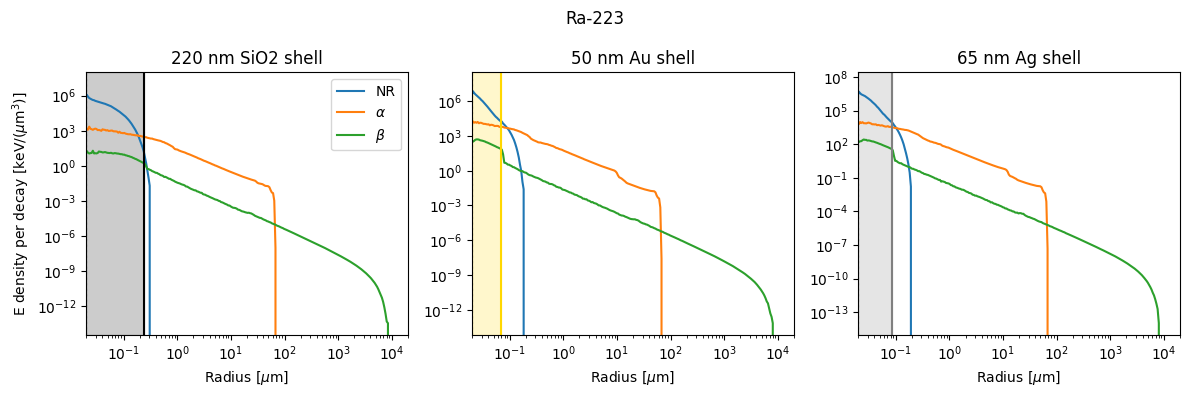

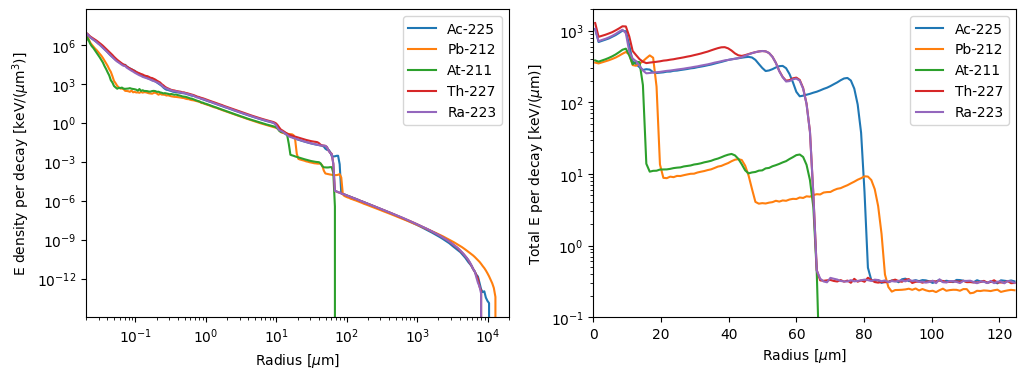

In [ ]:
ff = plt.figure(facecolor='white', figsize=(12,4))

for k,iso in enumerate(iso_list):

    df = plt.figure(facecolor='white', figsize=(12,4))

    for j,shell in enumerate(shell_mat):

        sphere_dict = {"inner_radius": 20, "outer_shell_thick": shell_thick[j], "inner_material": "SiO2", "shell_material": shell}

        router = sphere_dict['inner_radius'] + sphere_dict['outer_shell_thick']
        #bins_in = np.logspace(np.log10(0.1), np.log10(2*router), 50)
        #bins_in_size = bins_in[1] - bins_in[0]
        #bins_to_use = np.hstack( (bins_in, np.logspace(np.log10(2*router+4*bins_in_size), 8, 100) ) )
        bins_to_use = np.logspace(-1, 8, 400)
        bins_size = np.diff(bins_to_use)

        bins_to_use_lin = np.linspace(0, 125e3, 125)
        bins_size_lin = np.diff(bins_to_use_lin)

        cdata = np.load(fig_path + "energy_deposits_%s_%s.npz"%(iso, shell))
        h_NR, h_alpha, h_beta, bc, volume = cdata['h_NR'], cdata['h_alpha'], cdata['h_beta'], cdata['bc'], cdata['volume']

        cdata = np.load(fig_path + "energy_deposits_lin_bin_%s_%s.npz"%(iso, shell))
        h_NR_lin, h_alpha_lin, h_beta_lin, bc_lin, volume_lin = cdata['h_NR'], cdata['h_alpha'], cdata['h_beta'], cdata['bc'], cdata['volume']

        plt.figure(ff.number)
        if(j==1):
            plt.subplot(1,2,1)
            plt.loglog(bc*nm_to_um, h_NR + h_alpha + h_beta, label=iso)
            plt.xlim(0.02,2e4)
            plt.xlabel("Radius [$\mu$m]")
            plt.subplot(1,2,2)
            plt.semilogy(bc_lin*nm_to_um, (h_NR_lin + h_alpha_lin + h_beta_lin)*volume_lin/(bins_size_lin*nm_to_um), label=iso)

            print(iso, np.trapz((h_NR + h_alpha + h_beta)*volume/(bins_size*nm_to_um), bc*nm_to_um))
            print(iso, np.trapz((h_NR_lin + h_alpha_lin + h_beta_lin)*volume_lin/(bins_size_lin*nm_to_um), bc_lin*nm_to_um))

        plt.figure(df.number)
        plt.subplot(1,3,j+1)
        plt.loglog(bc*nm_to_um, h_NR, label='NR')
        plt.plot(bc*nm_to_um, h_alpha, label=r'$\alpha$')
        plt.plot(bc*nm_to_um, h_beta, label=r'$\beta$')
        plt.xlim(0.02,2e4)
        plt.xlabel("Radius [$\mu$m]")

        yy = plt.ylim()
        rinner = sphere_dict['inner_radius']
        plt.plot([rinner*nm_to_um, rinner*nm_to_um], yy, 'k:')
        plt.plot([router*nm_to_um, router*nm_to_um], yy, '-', color=col_list[j])
        plt.fill_between([rinner*nm_to_um, router*nm_to_um], yy[0], yy[1], color=col_list[j], alpha=0.2)
        plt.ylim(yy)

        if(j==0):
            plt.ylabel("E density per decay [keV/($\mu$m$^3$)]")
            plt.legend()
        plt.title("%d nm %s shell"%(shell_thick[j], shell))
    plt.suptitle(iso)
    plt.tight_layout()
    plt.savefig(fig_path + "e_density_%s.pdf"%iso)

plt.figure(ff.number)
plt.subplot(1,2,2)
plt.ylabel("Total E per decay [keV/($\mu$m)]")
plt.xlabel("Radius [$\mu$m]")
plt.legend()
plt.xlim(0,125)
plt.ylim(0.1,2000)
plt.subplot(1,2,1)
plt.legend()
plt.ylabel("E density per decay [keV/($\mu$m$^3$)]")
plt.xlabel("Radius [$\mu$m]")
plt.savefig(fig_path + "e_density_2panel.pdf")
#plt.gca().set_yscale('log')
#plt.ylim(0.1, 1e7)

KeyError: 'At-211_SiO2'

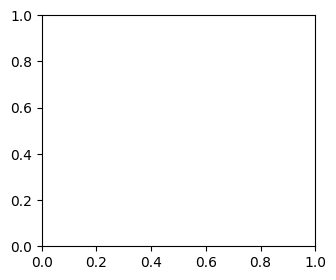

In [ ]:
## plot fraction escaping versus iso and thickness

plt.figure(facecolor='white', figsize=(12,3))

iso_list = ['At-211', 'Pb-212', 'Ra-223', 'Ac-225', 'Th-227']

cmap = plt.get_cmap('Blues_r')
n=6
colors = [cmap(i/(n-1)) for i in range(n)] 

rin = sphere_dict['inner_radius']

for j,shell in enumerate(shell_mat):
    
    plt.subplot(1,3,j+1)

    thick_dat = []
    for iso in iso_list:
        
        cdat = thickness_dict[iso + "_" + shell]

        thick_dat.append(cdat)

    thick_dat = np.array(thick_dat)
    for k in range(np.shape(thick_dat)[1]):
        plt.plot( thick_dat[:,k]-rin, '-o', color=colors[k], label="%g%%"%(thresh_list[k]*100))
    yy = plt.ylim()
    plt.ylim([0,yy[1]])
    ax = plt.gca()
    ax.set_xticks(range(len(iso_list)))
    ax.set_xticklabels(iso_list)
    plt.ylabel("Shell thickness [nm]")

    if(j == 0):
        [plt.legend()]

    plt.grid(True)

    plt.title(shell)
    plt.tight_layout()
    plt.savefig(fig_path + "shell_vs_escape.pdf")

Found 14 bad points out of 20000: 0.070%


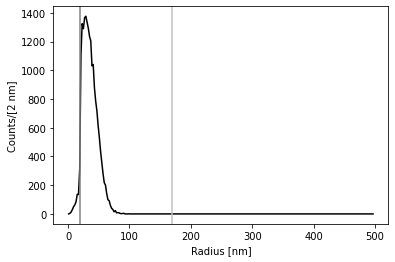

In [ ]:
importlib.reload(ar)
ar.analyze_simulation(sim_dict['Ac-225_Au'], sphere_dict)

In [39]:
importlib.reload(ar)

iso = "Ac-225"
shell = "Au"
num = 10

shell_mat = ['SiO2', 'Au', 'Ag']
shell_thick = [350, 100, 150]

sphere_dict['shell_material'] = shell
sphere_dict['outer_shell_thick'] = 60

plt.close('all')
fig = ar.plot_event(sim_dict[iso + "_" + shell][num], sphere_dict, plot_alphas=True, plot_betas=True)
#plt.savefig(fig_path + "examp_traj_%s_%s_%d.png"%(iso, shell, num), dpi=300)

plt.show()

KeyError: 10